In [1]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensor
warnings.filterwarnings("ignore")
import segmentation_models_pytorch as smp

## Dataloader
Pytorch custom dataloader

In [10]:
class MCDataset(Dataset):
    def __init__(self, df, size, mean, std, phase):
        self.df = df
        self.size = size
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, size, mean, std)

    def __getitem__(self, idx):
        image_path = self.df['image'].iloc[idx]
        dmap_path = self.df['map'].iloc[idx]
        image = cv2.imread(image_path)
        dmap = cv2.imread(dmap_path)
        dmap = dmap[:,:,0]
        augmented = self.transforms(image=image, mask=dmap)
        image = augmented['image']
        dmap = augmented['mask']
        return image, dmap

    def __len__(self):
        return len(self.df)


def get_transforms(phase, size, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
#                 HorizontalFlip(),
                ShiftScaleRotate(
                    shift_limit=0,  # no resizing
                    scale_limit=0.1,
                    rotate_limit=10, # rotate
                    p=0.5,
                    border_mode=cv2.BORDER_CONSTANT
                ),
#                 GaussNoise(),
            ]
        )
    list_transforms.extend(
        [
            Resize(size, size),
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )

    list_trfms = Compose(list_transforms)
    return list_trfms

def provider(
    fold,
    total_folds,
    df_path,
    phase,
    size,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=0,
):
    df = pd.read_csv(df_path)
    df = df.sample(frac=0.2)
    kfold = KFold(total_folds, shuffle=True, random_state=69)
    train_idx, val_idx = list(kfold.split(df["image"], df["map"]))[fold]
    train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]
    df = train_df if phase == "train" else val_df
    # NOTE: total_folds=5 -> train/val : 80%/20%
    
    image_dataset = MCDataset(df,size, mean, std, phase)

    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
    return dataloader

### Dataloader sanity check

In [152]:
dataloader = provider(
    fold=0,
    total_folds=5,
    df_path="/home/rath772k/2dtodepth/2dtodepth/data.csv",
    phase="train",
    size=256,
    mean = (0.485, 0.456, 0.406),
    std = (0.229, 0.224, 0.225),
    batch_size=16,
    num_workers=0,
)

In [153]:
batch = next(iter(dataloader)) # get a batch from the dataloader
images, masks = batch

### sanity check

In [26]:
df=pd.read_csv('/home/rath772k/2dtodepth/2dtodepth/data.csv')

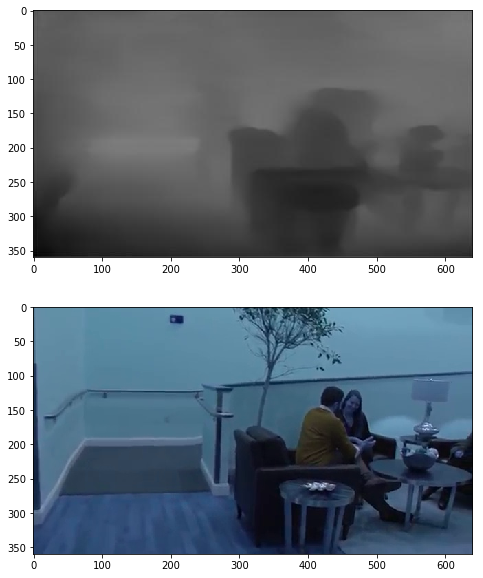

In [128]:
image = df['image'].iloc[0]
mask = df['map'].iloc[0]
image=cv2.imread(image)
mask = cv2.imread(mask)
fig=plt.figure(figsize=(10,10))
fig.add_subplot(2,1,1)
plt.imshow(mask)
fig.add_subplot(2,1,2)
plt.imshow(image)
plt.show()

In [141]:
# plot some random images in the `batch`
idx = random.choice(range(16))

image=images[idx].numpy()
image = image.transpose((1,2,0))
mask=masks[idx].numpy()
mask.shape.reshape(())

(1, 256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


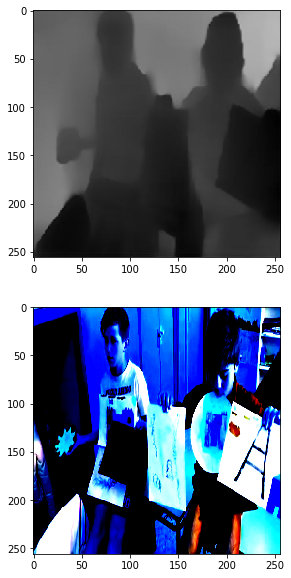

In [144]:
# plot some random images in the `batch`
idx = random.choice(range(16))

image=images[idx].numpy()
image = image.transpose((1,2,0))
mask=masks[idx].numpy()
mask=mask.reshape((256,256,3))
fig=plt.figure(figsize=(10,10))
fig.add_subplot(2,1,1)
plt.imshow(mask)
fig.add_subplot(2,1,2)
plt.imshow(image)
plt.show()

## Losses

This kernel uses a weighted sum of RMSE Loss in log space

In [11]:
class RMSE_log(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, fake, real):
        #fake = torch.clamp(fake,min=1)
        real = torch.clamp(real,min=1)
        loss = torch.sqrt( torch.mean( torch.abs(torch.log(real)-torch.log(fake)) ** 2 ))
        return loss

In [12]:
class Meter:
    '''A meter to keep track of si-rmse scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.si_rmse=[]

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        si_rmse = compute_si_rmse_batch(probs,targets)
        self.si_rmse.append(si_rmse)    
        
    def get_metrics(self):
        si_rmse = np.nanmean(self.si_rmse)
        return si_rmse

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    si_rmse = meter.get_metrics()
    print("Loss: %0.4f | si-rmse: %0.4f" % (epoch_loss, si_rmse))
    return si_rmse

def compute_si_rmse(prob, target):
    mse = (np.square(prob - target)).mean(axis=None)
    mean = np.mean(prob)
    return mse/(mean+1e-9)

def compute_si_rmse_batch(probs, targets):
    si_rmses = []
    preds = np.copy(probs)
    labels = np.array(targets)
    for pred,target in zip(preds,labels):
        si_rmses.append(compute_si_rmse(pred,target))
    return np.nanmean(si_rmses)



## UNet with ResNet34 model
Let's take a look at the model

In [6]:
model = smp.Unet("efficientnet-b3", encoder_weights="imagenet", activation="sigmoid")

## Model Training and validation

In [8]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model):
        self.fold = 1
        self.total_folds = 5
        self.num_workers = 0
        self.batch_size = {"train": 4, "val": 4}
        self.accumulation_steps = 32 // self.batch_size['train']
        self.lr = 5e-4
        self.num_epochs = 10
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        #self.criterion = MixedLoss(10.0,2.0)
        self.criterion = RMSE_log()
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                fold=1,
                total_folds=5,
                df_path="/home/rath772k/2dtodepth/2dtodepth/data.csv",
                phase=phase,
                size=256,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.si_rmse = {phase: [] for phase in self.phases}
        
    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)
        return loss, outputs

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
        #tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(dataloader):
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
            #tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        si = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.si_rmse[phase].append(si)
        torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            val_loss = self.iterate(epoch, "val")
            self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./model_dp.pth")
            print()

In [13]:
model_trainer = Trainer(model)
#model_trainer.start()

In [14]:
model = model_trainer.net
#torch.save(model,"/home/rath772k/dp.pth")
state = torch.load('./model_dp.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])

<All keys matched successfully>

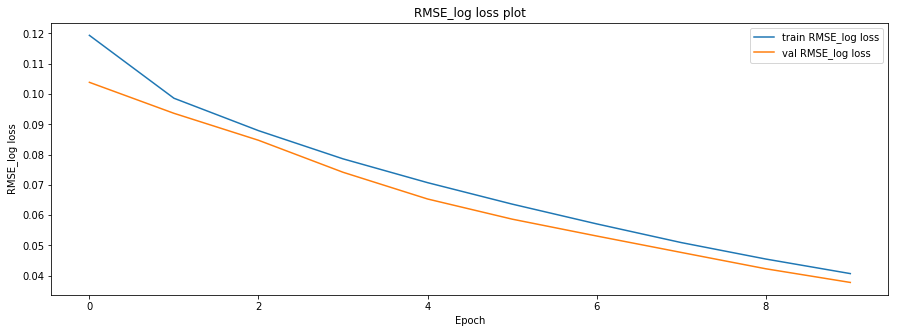

In [234]:
# PLOT TRAINING
losses = model_trainer.losses

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

plot(losses, "RMSE_log loss")


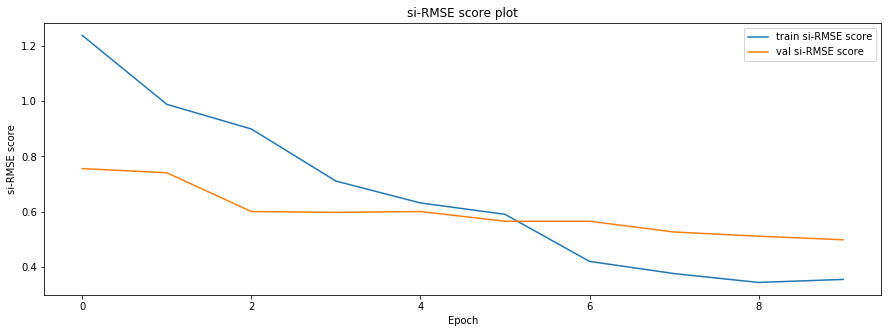

In [53]:
si_rmse=model_trainer.si_rmse
plot(si_rmse, "si-RMSE score")

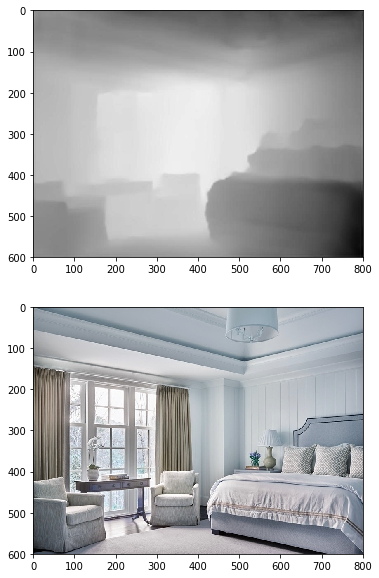

In [51]:
image = '/home/rath772k/aa.jpg'
image=cv2.imread(image)
size = 256
transform = Compose([
            Resize(size, size),
            ToTensor(),
            ])
image_in = transform(image=image)["image"]
image_in = image_in.reshape(1, 3, 256, 256).to(torch.device("cpu"))
model.eval()
model.to(torch.device("cpu"))
with torch.no_grad():
    op = model(image_in)
    op = op.cpu().numpy()
fig=plt.figure(figsize=(10,10))
fig.add_subplot(2,1,2)
plt.imshow(image,shape=(256,256))
fig.add_subplot(2,1,1)
plt.imshow(op.reshape((256,256)),cmap="gray")
plt.show()